# Random Forest Model for NEK 9
## Chongye Feng
## Berkeley ATOM 2024

In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from imblearn.ensemble import BalancedRandomForestClassifier

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Save models
import joblib

import random
random.seed(2024)

In [2]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
uq_path = "../../../data/NEK_data_4Berkeley/NEK9"
train_x_df = pd.read_csv(uq_path+"/NEK9_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(uq_path+"/NEK9_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(uq_path+"/NEK9_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(uq_path+"/NEK9_binding_random_fold1_testY.csv")
test_x_df

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,8.863331,200.55731,8.744996,211.27695,13.146599,-2.579430,-0.583490,0.596628,2.578217,-0.053647,...,12.794271,213.125,53.875,20.250,6.000,0.625,0.0,1629,0.958333,3.000000
1,5.710754,308.49966,8.336615,103.68244,9.665877,-2.684462,-0.545481,0.612510,2.829763,-0.044527,...,7.360577,155.750,34.250,13.375,4.375,0.125,0.0,6960,0.935897,3.076923
2,7.641164,234.83014,10.412645,114.83887,13.022620,-2.286437,-0.650007,0.646905,2.255628,-0.055883,...,11.750000,142.750,48.500,20.000,5.000,0.000,0.0,1836,0.977273,3.272727
3,7.728748,250.53065,8.216459,234.36145,13.424491,-2.349532,-0.622879,0.664782,2.752413,-0.055313,...,11.805556,165.875,27.500,10.250,2.500,0.000,0.0,1981,1.000000,3.511111
4,7.777926,360.22958,9.405464,269.08743,14.210598,-2.350545,-0.644264,0.610369,2.781659,-0.041713,...,12.035714,199.250,41.250,18.875,6.875,1.000,0.0,4576,1.053571,3.535714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,8.375013,138.32080,8.325641,141.62868,10.439502,-2.673598,-0.529197,0.628161,2.667173,-0.051933,...,9.250000,164.250,29.875,9.125,2.250,0.000,0.0,5007,0.805970,2.835821
279,7.279829,393.08694,9.612618,271.78192,14.839193,-2.313895,-0.637220,0.660727,2.370738,-0.046257,...,12.149038,170.125,37.125,13.625,3.750,0.000,0.0,5098,1.038462,3.653846
280,7.053889,166.09090,6.883618,178.69096,9.298361,-2.801674,-0.495829,0.594997,2.783073,-0.047220,...,6.896959,131.625,22.125,7.250,1.875,0.000,0.0,5079,0.918919,2.810811
281,8.538722,185.80338,8.776142,171.08333,11.535550,-2.771892,-0.510433,0.662294,2.732305,-0.056566,...,10.076613,184.500,36.750,14.125,2.375,0.000,0.0,3781,0.822581,2.870968


In [4]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

print(train_x.shape)
print(train_y.shape)

(1126, 306)
(1126,)


In [5]:
# Construct a RF classification model

# creating a RF classifier
clf_balanced = BalancedRandomForestClassifier(n_estimators = 100, class_weight = "balanced")  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_balanced.fit(train_x, train_y)
 
# performing predictions on the test dataset
train_pred_y = clf_balanced.predict(train_x)
test_pred_y = clf_balanced.predict(test_x)

/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

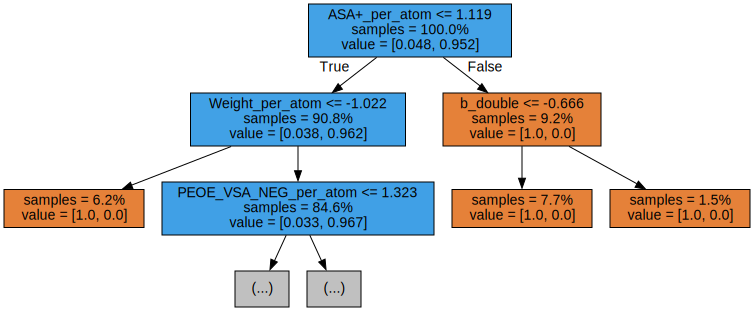

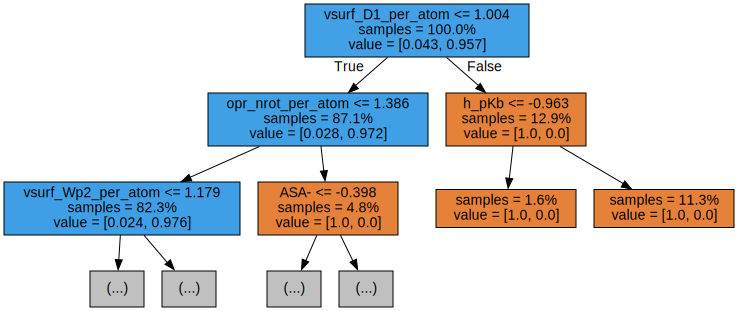

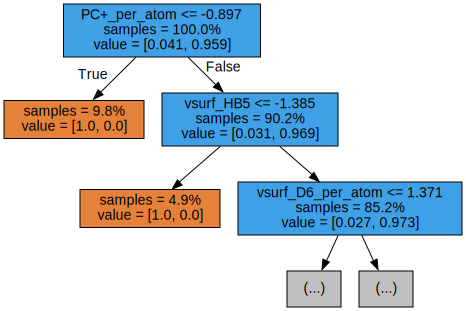

In [6]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = clf_balanced.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Confusion matrix, without normalization
[[758 320]
 [  0  48]]


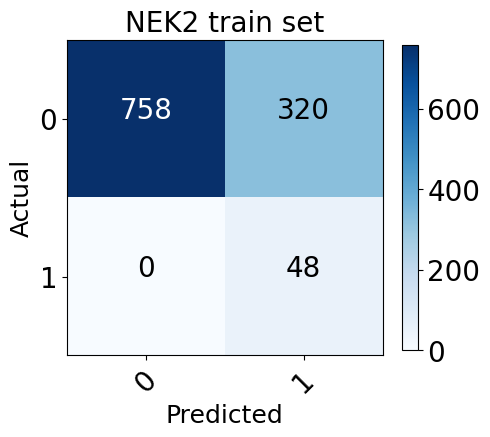

In [7]:
# Create the confusion matrix
train_cm = confusion_matrix(train_y, train_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


Confusion matrix, without normalization
[[191  79]
 [  8   5]]


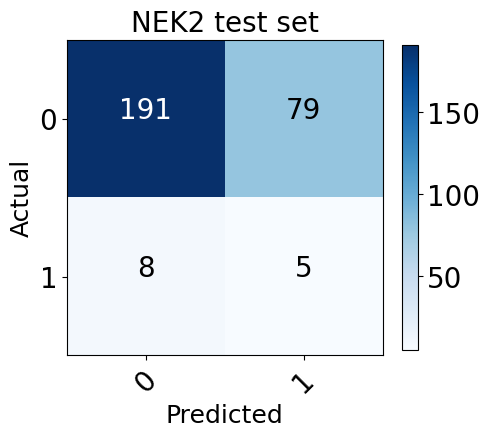

In [8]:
# Create the confusion matrix
test_cm = confusion_matrix(test_y, test_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

## HyperParameter Tuning

In [9]:
# This takes a long time. Try loading the saved model.
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,80)}

# Create a random forest classifier
rf = BalancedRandomForestClassifier(class_weight = "balanced")

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

RandomizedSearchCV(cv=5,
                   estimator=BalancedRandomForestClassifier(class_weight='balanced'),
                   n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f013f547e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f006289c310>})

In [10]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Best hyperparameters: {'max_depth': 68, 'n_estimators': 312}

Best hyperparameters: {'max_depth': 59, 'n_estimators': 167}


In [11]:
# # Using GPU acceleration

# from cuml.ensemble import RandomForestClassifier as cuRF
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Define your parameter distribution
# param_dist = {'n_estimators': randint(50,500),
#               'max_depth': randint(1,80)}

# # Create a cuml random forest classifier (Note: This does not handle class imbalance directly)
# rf = cuRF()

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=30, 
#                                  cv=5,
#                                  random_state=42)

# # Assuming train_x and train_y are cuDF DataFrame or Series
# # Fit the random search object to the data
# rand_search.fit(train_x, train_y)


ImportError: cannot import name 'MachAr' from 'numpy' (/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/numpy/__init__.py)

In [12]:
# Save the best model

# save
joblib.dump(best_rf, "balanceRFC_randomCV_NEK9_binding.pkl") 

# load
#clf2 = joblib.load("balanceRFC_randomCV_NEK9_binding.pkl")
#clf2.predict(X[0:1])

['balanceRFC_randomCV_NEK9_binding.pkl']

Confusion matrix, without normalization
[[747 331]
 [  0  48]]


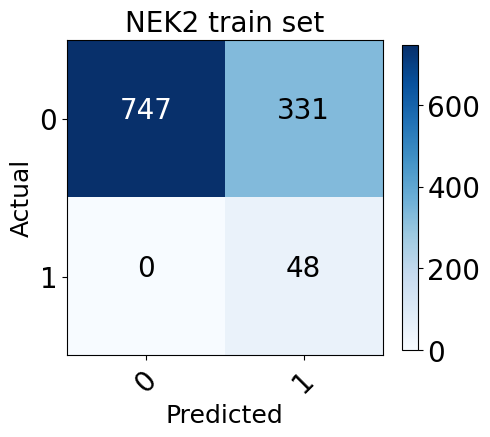

In [13]:
# Generate predictions with the best model
train_pred_y_best = best_rf.predict(train_x)

# Create the confusion matrix
train_best_cm = confusion_matrix(train_y, train_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Confusion matrix, without normalization
[[188  82]
 [  7   6]]


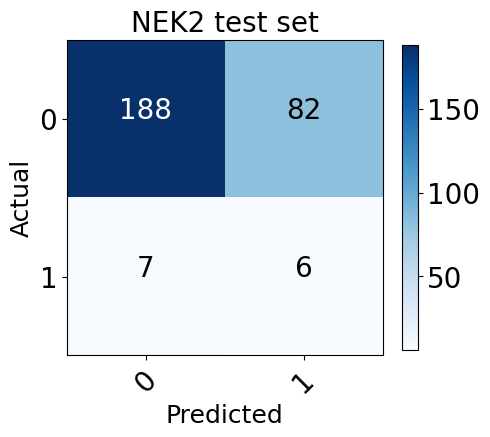

In [14]:
# Generate predictions with the best model
test_pred_y_best = best_rf.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

In [15]:
accuracy = accuracy_score(test_y, test_pred_y_best)
precision = precision_score(test_y, test_pred_y_best)
recall = recall_score(test_y, test_pred_y_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6855123674911661
Precision: 0.06818181818181818
Recall: 0.46153846153846156


## GridSearch CV

In [18]:
# This takes a very long time. Try load from the best model.
param_grid = {
    'n_estimators': np.linspace(100, 2000, 5, dtype = int),
    'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5]
}

# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = 8, verbose = 2)
grid_rf_search.fit(train_x, train_y)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   3.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1525; total time=   8.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=575; total time=   3.2s
[CV] END max_depth=20, min

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=8,
             param_grid={'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([ 100,  575, 1050, 1525, 2000])},
             verbose=2)

In [17]:
# import numpy as np
# import cuml
# from cuml.ensemble import RandomForestClassifier as cuRF
# from sklearn.model_selection import ParameterGrid

# # Define your parameter grid
# param_grid = {
#     'n_estimators': np.linspace(100, 2000, 5, dtype=int),
#     'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [2, 3, 4, 5]
# }

# # Best model placeholder and score tracker
# best_model = None
# best_score = 0

# # Iterate over the parameter grid
# for params in ParameterGrid(param_grid):
#     model = cuRF(**params, criterion='entropy', bootstrap=True)
#     model.fit(train_x, train_y)
    
#     # Assuming you have a validation set or using cross-validation to get the score
#     # For demonstration, replace this with your actual validation approach
#     score = model.score(validation_x, validation_y)
    
#     if score > best_score:
#         best_model = model
#         best_score = score

# print(f"Best Score: {best_score}")


ImportError: cannot import name 'MachAr' from 'numpy' (/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/numpy/__init__.py)

In [28]:
# from cuml.ensemble import RandomForestClassifier as cuRF
# from cuml.model_selection import train_test_split
# from cuml.metrics.accuracy import accuracy_score

# # Assuming your data is already loaded and available as train_x and train_y
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)

# # Create a cuML random forest classifier
# cu_rf = cuRF(n_estimators=100, max_depth=10)

# # Fit the model
# cu_rf.fit(X_train, y_train)

# # Predict and calculate accuracy
# y_pred = cu_rf.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))


ModuleNotFoundError: No module named 'cuml'

In [19]:
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

# {'max_depth': 20,
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 100}

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [21]:
# Save the best model

# save
# joblib.dump(best_rf_grid, "balanceRFC_gridCV_NEK9_binding.pkl") 

# load
best_rf_grid = joblib.load("balanceRFC_gridCV_NEK9_binding.pkl")
best_rf_grid.predict(train_x[0:1])

/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([0])

Confusion matrix, without normalization
[[1078    0]
 [   5   43]]


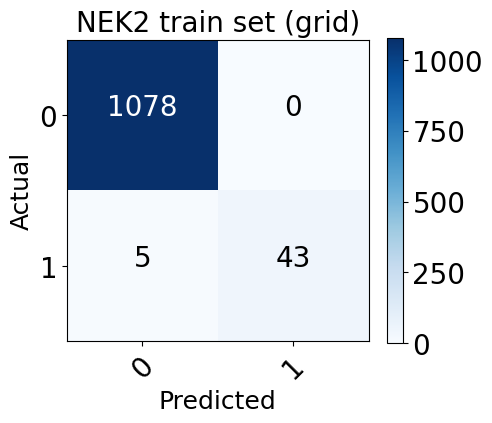

In [22]:
# Generate predictions with the best model
train_pred_y_best = best_rf_grid.predict(train_x)

# Create the confusion matrix
train_best_cm = confusion_matrix(train_y, train_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set (grid)",fontsize=20)
plot_confusion_matrix(train_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Confusion matrix, without normalization
[[1078    0]
 [   0   48]]


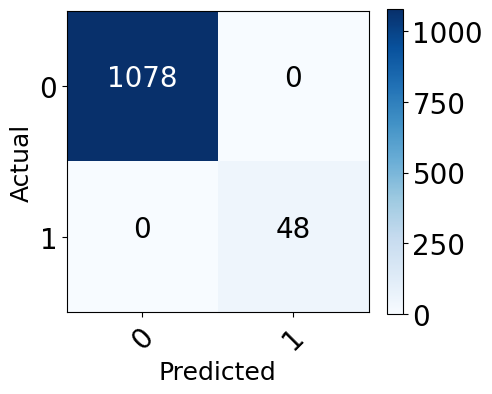

In [27]:
# Step 1: Predict probabilities for the positive class
probabilities = best_rf_grid.predict_proba(train_x)[:, 1]  # Get probabilities for class '1'

# Step 2: Define a new threshold
threshold = 0.3 

# Step 3: Apply threshold to convert probabilities to binary predictions
# Compare probabilities to threshold to create binary predictions
predictions_with_new_threshold = (probabilities >= threshold).astype(int)

# Create the confusion matrix with the new predictions
new_confusion_matrix = confusion_matrix(train_y, predictions_with_new_threshold)

# Plot the new confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(new_confusion_matrix, classes=class_names, normalize=False)
plt.xlabel("Predicted", fontdict=label_font)
plt.ylabel("Actual", fontdict=label_font)
plt.show()

Confusion matrix, without normalization
[[270   0]
 [ 13   0]]


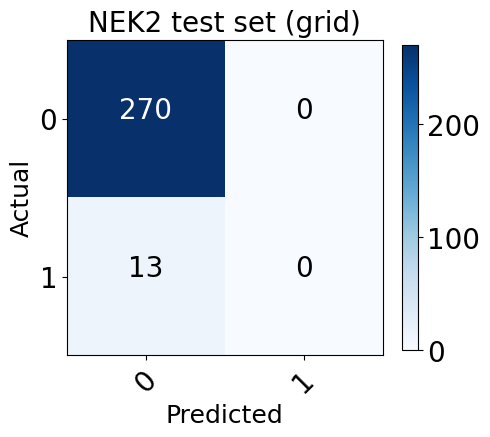

In [28]:
# Generate predictions with the best model
test_pred_y_best = best_rf_grid.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set (grid)",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Confusion matrix, without normalization
[[ 42 228]
 [  0  13]]


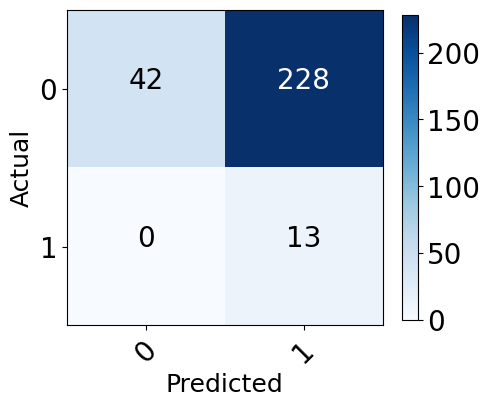

In [36]:
# Step 1: Predict probabilities for the positive class
probabilities = best_rf_grid.predict_proba(test_x)[:, 1]  # Get probabilities for class '1'

# Step 2: Define a new threshold
threshold = 0.006  

# Step 3: Apply threshold to convert probabilities to binary predictions
# Compare probabilities to threshold to create binary predictions
predictions_with_new_threshold = (probabilities >= threshold).astype(int)

# Create the confusion matrix with the new predictions
new_confusion_matrix = confusion_matrix(test_y, predictions_with_new_threshold)

# Plot the new confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(new_confusion_matrix, classes=class_names, normalize=False)
plt.xlabel("Predicted", fontdict=label_font)
plt.ylabel("Actual", fontdict=label_font)
plt.show()

In [37]:
accuracy = accuracy_score(test_y, test_pred_y_best)
precision = precision_score(test_y, test_pred_y_best)
recall = recall_score(test_y, test_pred_y_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9540636042402827
Precision: 0.0
Recall: 0.0


/home/chongyef/miniconda3/envs/rapids-0.19/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RF Variance

In [23]:
np.arange(len(best_rf_grid.estimators_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [24]:
# Tree predictions
train_proba0_df = pd.DataFrame()
train_proba1_df = pd.DataFrame()
test_proba0_df = pd.DataFrame()
test_proba1_df = pd.DataFrame()

for tree_num in np.arange(len(best_rf_grid.estimators_)):
    train_proba_temp = best_rf_grid.estimators_[tree_num].predict_proba(train_x)
    train_proba0_df[tree_num] = train_proba_temp[:,0]
    train_proba1_df[tree_num] = train_proba_temp[:,1]
    test_proba_temp = best_rf_grid.estimators_[tree_num].predict_proba(test_x)
    test_proba0_df[tree_num] = test_proba_temp[:,0]
    test_proba1_df[tree_num] = test_proba_temp[:,1]
    
train_proba0_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0
1,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0
2,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0
3,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0
4,1.0,1.000000,1.0,0.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0.0,0.500000,0.0,1.0,0.0,0.0,0.333333,0.0,0.000000,0.000000,...,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
1122,0.0,0.000000,0.0,1.0,1.0,0.0,0.000000,0.0,1.000000,0.000000,...,1.0,1.0,0.0,0.000000,0.0,1.0,0.5,0.000000,0.0,0.0
1123,1.0,0.000000,0.0,0.0,1.0,0.0,1.000000,1.0,1.000000,0.000000,...,1.0,0.0,1.0,0.000000,0.0,1.0,0.0,1.000000,0.0,0.0
1124,0.0,0.333333,0.0,0.0,0.0,1.0,0.666667,0.0,1.000000,0.333333,...,0.0,1.0,0.0,0.333333,0.0,1.0,0.0,0.666667,0.0,0.0


In [25]:
std = test_proba0_df.std(axis=1)
std

0      0.000000
1      0.305972
2      0.070963
3      0.140705
4      0.233694
         ...   
278    0.178464
279    0.293643
280    0.263283
281    0.072864
282    0.215368
Length: 283, dtype: float64

### Saving them ...

In [26]:
# Empty dataframe
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()

# Predictions
train_perf_df['train_y_pred_grid'] = train_pred_y_best
test_perf_df['test_y_pred_grid'] = test_pred_y_best

# Actual
train_perf_df['train_y'] = train_y
test_perf_df['test_y'] = test_y

# Variances
train_perf_df['train_proba0_std_grid'] = train_proba0_df.std(axis=1)
train_perf_df['train_proba1_std_grid'] = train_proba1_df.std(axis=1)
test_perf_df['test_proba0_std_grid'] = test_proba0_df.std(axis=1)
test_perf_df['test_proba1_std_grid'] = test_proba1_df.std(axis=1)

train_perf_df

,train_y_pred_grid,train_y,train_proba0_std_grid,train_proba1_std_grid
0,0,0,0.082928,0.082928
1,0,0,0.000000,0.000000
2,0,0,0.000000,0.000000
3,0,0,0.070353,0.070353
4,0,0,0.216492,0.216492
...,...,...,...,...
1121,1,1,0.426351,0.426351
1122,1,1,0.421251,0.421251
1123,1,1,0.454420,0.454420
1124,1,1,0.433441,0.433441


In [27]:
train_perf_df.to_csv("RFC_NEK9_Binding_train_perf.csv", index=False)
test_perf_df.to_csv("RFC_NEK9_Binding_test_perf.csv", index=False)

[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=3, n_estimators=575; total time=   3.3s
[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=3, n_estimators=1050; total time=   6.1s
[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=3, n_estimators=1525; total time=   9.1s
[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=4, n_estimators=575; total time=   3.2s
[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=4, n_estimators=1050; total time=   5.9s
[CV] END max_depth=200, min_samples_leaf=2, min_samples_split=4, n_estimators=1525; total time=   8.6s
[CV] END max_depth=200, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=200, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=200, min_samples_leaf=3, min_samples_split=2, n_estimators=